# <center>用神经微分方程拟合动力系统</center>

## 1. 问题描述

考虑一个描述向内收缩的螺旋线的二维线性常微分方程组
$$
\mathbf{y} (0) = \mathbf{y}^{\textnormal{ini}}, \ \
\frac{d \mathbf{y} (t)}{dt} = f( \mathbf{y} (t), t )
\ \ \
\textnormal{for}
\ \ \
t_0 < t\leq t_1,
$$
其中 $t_0 = 0$，$t_1 = 10$，$ \mathbf{y}(0) = \begin{pmatrix} y_1(0) \\ y_2(0) \end{pmatrix}$ 为初始出发位置，右端项 $
f( \mathbf{y} (t), t )
=
\begin{bmatrix}
-0.1 & 2 \\
-2 & -0.1
\end{bmatrix}
\begin{pmatrix} y_1(t) \\ y_2(t) \end{pmatrix}.
$
在很多现实问题中，上述常微分方程的右端项函数 $f( \mathbf{y} (t), t )$ 是未知的，如何通过离散轨迹点 $\{ \mathbf{y} (t_i) \}_{i=1}^N$ 的观测数据来反演整个动力学系统的行为，是一个有趣且重要的科学问题。


### 神经微分方程

将未知的右端项函数 $f( \mathbf{y} (t), t )$ 用神经网络参数化，即
$$
f( \mathbf{y} (t), t ) \approx f_{\textnormal{NN}}( \mathbf{y} (t), t; \theta )
$$
其中 $\theta$ 代表神经网络的可训练参数，相应的训练任务可以表达为以下优化问题
\begin{equation*}
	\begin{array}{cl}
		\displaystyle  \min_\theta & \displaystyle \sum_{i=1}^N \lVert \mathbf{y}_{\textnormal{NN}} (t_i) - \mathbf{y} (t_i) \rVert^2 \\
		\textnormal{s.t.} & \displaystyle  \mathbf{y}_{\textnormal{NN}} (0) = \mathbf{y}^{\textnormal{ini}}, \ \
\frac{d \mathbf{y}_{\textnormal{NN}} (t)}{dt} = f_{\textnormal{NN}}( \mathbf{y}_{\textnormal{NN}} (t), t; \theta )
\ \ \
\textnormal{for}
\ \ \
t_0 < t\leq t_1.
	\end{array}
\end{equation*}

### 伴随方程方法

在科学计算的变分原理中，$\mathbf{y}_{\textnormal{NN}} (t)$ 对应于状态变量，$\theta$ 对应于控制变量，因此可以通过变分原理（Calculus of Variations）来求解上述问题。特别的，torchdiffeq 库中的 odeint 函数巧妙地封装了整个过程，相较于离散的残差网络等模型，在内存效率和计算效率方面有明显的优势。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

import time
import datetime

## 1. 数据生成

用 scipy 提供的求解器来计算常微分方程组的数值解，并以此作为动力系统的观测数据（后续右端项将假设是未知的）

In [2]:
# exact right-hand-side function, i.e., dydt
def Exact_RHS_Func(t, y):
    return np.array([[-0.1, 2.0], [-2.0, -0.1]]) @ y

# problem setting
t_ini = 0; t_end = 10 # time interval
num_trjs = 50
num_smps = 101
smp_pts = np.linspace(t_ini, t_end, num_smps)

ini_vals = [] # initial values
ref_trjs = [] # reference solution for each initial value

np.random.seed(42) # for reproducibility
for _ in range(num_trjs):
    
    ratio = np.random.uniform(0.8, 1.2)
    angle = np.random.uniform(0, 2 * np.pi)
    ini_val = np.array([ratio * np.cos(angle), ratio * np.sin(angle)]) # initial value for each trajectory
    ini_vals.append(ini_val)
    
    # numerical solution through scipy
    ref_trj = solve_ivp(Exact_RHS_Func, (t_ini, t_end), ini_val, t_eval=smp_pts, dense_output=True, rtol=1e-8, atol=1e-8)
    ref_trjs.append(ref_trj.y.T) 

ini_vals = np.array(ini_vals) # shape: [num_trjs, 2]
ref_trjs = np.array(ref_trjs) # shape: [num_trjs, num_smps, 2]

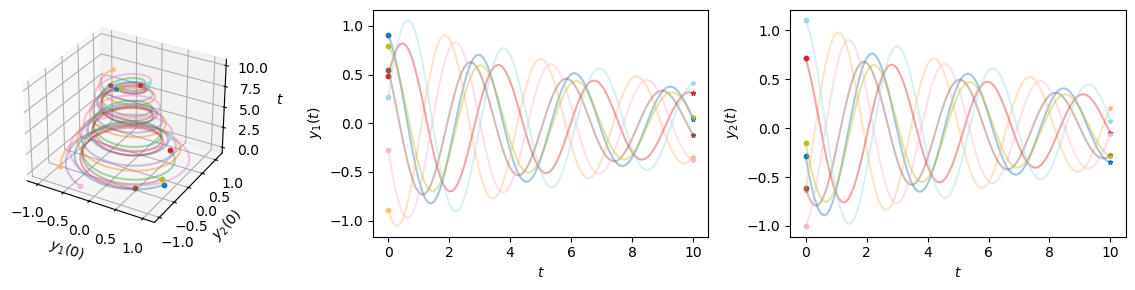

In [3]:
def plot_trajectories(time_span, trajectories):
    
    fig = plt.figure(figsize=(12, 3))
    ax = fig.add_subplot(131, projection='3d')
    colors = plt.cm.tab20(np.linspace(0, 1, min(trajectories.shape[0], 7)))
    for i in range(min(trajectories.shape[0], 7)):
        ax.scatter(ini_vals[i, 0], ini_vals[i, 1], t_ini, color=colors[i], marker='o', s=10) 
        ax.plot(trajectories[i, :, 0], trajectories[i, :, 1], time_span, alpha=0.4)
        ax.scatter(trajectories[i, num_smps-1, 0], trajectories[i, num_smps-1, 1], t_end, color=colors[i], marker='*', s=10) 
                
    # ax.set_title('3D Trajectories')
    ax.set_xlabel(r"$y_1(0)$")
    ax.set_ylabel(r"$y_2(0)$")
    ax.set_zlabel(r"$t$")     

    ax0 = fig.add_subplot(132)
    ax1 = fig.add_subplot(133)
    for i in range(min(trajectories.shape[0], 7)):
        
        ax0.scatter(t_ini, ini_vals[i, 0], color=colors[i], marker='o', s=10)
        ax0.plot(time_span, trajectories[i, :, 0], color=colors[i], alpha=0.4)        
        ax0.scatter(t_end, trajectories[i, num_smps-1, 0], color=colors[i], marker='*', s=10)
        
        ax1.scatter(t_ini, ini_vals[i, 1], color=colors[i], marker='o', s=10)
        ax1.plot(time_span, trajectories[i, :, 1], color=colors[i], alpha=0.4)
        ax1.scatter(t_end, trajectories[i, num_smps-1, 1], color=colors[i], marker='*', s=10)

    ax0.set_xlabel(r"$t$")
    ax0.set_ylabel(r"$y_1(t)$")
    ax1.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$y_2(t)$")

    plt.tight_layout()
    
plot_trajectories(smp_pts, ref_trjs)

## 2. 创建神经微分方程模型

首先用神经网络参数化右端项函数，其模型参数即为控制变量，接着通过 torchdiffeq 的 odeint 模块来实现神经微分方程的前向、反向传播

In [4]:
class NN_RHS_Func(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN_RHS_Func, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim),
        )
        
        # Xavier initialization
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
                nn.init.zeros_(m.bias)

    def forward(self, t, y):
        # time variable is not used in this example
        return self.net(y)

class Neural_ODE(nn.Module):
    def __init__(self, ode_func):
        super(Neural_ODE, self).__init__()
        self.ode_func = ode_func

    def forward(self, y0_batch, t_points, method='dopri5', rtol=1e-5, atol=1e-7):
        """
        y0_batch: initial value, shape: [batch_size, state_dim]
        t_points: temporal grid points, shape: [num_smps]
        """
        
        solver_options = {} # additional hyperparameters, e.g., 'step_size' 
        # compute solution values at grid points, together with calculation of gradient through adjoint equation for loss.backward()
        pred_y_batch = odeint(
            self.ode_func, 
            y0_batch, 
            t_points, 
            method=method, # method='dopri5' by default
            rtol=rtol, # relative tolerance
            atol=atol, # absolute tolerance
            options=solver_options 
        )
        
        # output shape: [num_smps, batch_size, state_dim] -> [batch_size, num_smps, state_dim]
        return pred_y_batch.permute(1, 0, 2)

## 3. 训练控制变量

通过求解伴随方程，调整可训练参数使得神经微分方程能够拟合好观测数据

device: cpu
Done in 0:03:59.681093 !


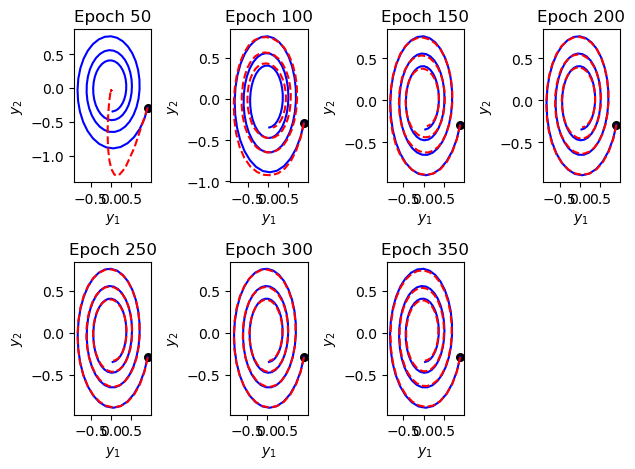

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

# construct neural ODE model
input_dim = 2
output_dim = 2
hidden_dim = 64 

RHS_NN = NN_RHS_Func(input_dim, hidden_dim, output_dim).to(device)
ODE_NN = Neural_ODE(RHS_NN).to(device)

# load data to CPU or GPU in tensor format
smp_pts = torch.from_numpy(smp_pts).float().to(device)
ini_vals = torch.from_numpy(ini_vals).float().to(device)
ref_trjs = torch.from_numpy(ref_trjs).float().to(device)

# mean square loss
criterion = nn.MSELoss()
# optimizer
milestones = [200, 300] # for decay of learning rate
optimizer = torch.optim.AdamW(ODE_NN.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

num_epochs = 350 
batch_size = 5 

since = time.time()
for epoch in range(num_epochs):

    # set model to training mode
    ODE_NN.train()         
    
    for i in range(0, ini_vals.size(0), batch_size):        
        
        ini_vals_minibatch = ini_vals[i : i + batch_size]
        ref_trjs_minibatch = ref_trjs[i : i + batch_size]
        
        # forward pass through neural ODE
        prd_trjs_minibatch = ODE_NN(ini_vals_minibatch, smp_pts)
        
        # calculate loss function
        loss = criterion(prd_trjs_minibatch, ref_trjs_minibatch)

        # zero parameter gradients
        optimizer.zero_grad()
        # backpropagation
        loss.backward()        
        # update network parameter 
        optimizer.step()        

    # display results as training progresses
    list_of_plots = []
    plt.rcdefaults()

    if (epoch+1) % 50 == 0: 
        ax = plt.subplot(2, 4, epoch // 50 + 1)

        ODE_NN.eval() 
        with torch.no_grad():
            
            ini_val_test = ini_vals[0:1] # require dimension of batch
            prd_trj_test = ODE_NN(ini_val_test, smp_pts).cpu().numpy()
            
            ax.plot(ref_trjs[0, :, 0].cpu().numpy(), ref_trjs[0, :, 1].cpu().numpy(), label='Exact Trajectory', color='blue')
            ax.plot(prd_trj_test[0, :, 0], prd_trj_test[0, :, 1], label='Predicted Trajectory', color='red', linestyle='--')
            ax.scatter(ini_val_test[0, 0].cpu(), ini_val_test[0, 1].cpu(), marker='o', color='black', s=30)
            ax.set_title(f'Epoch {epoch+1}')
            ax.set_xlabel('$y_1$')
            ax.set_ylabel('$y_2$')

            list_of_plots.append(ax) 
            plt.tight_layout()

time_elapsed = time.time() - since
print('Done in {}'.format(str(datetime.timedelta(seconds=time_elapsed))), '!')

## 4. 测试训练模型

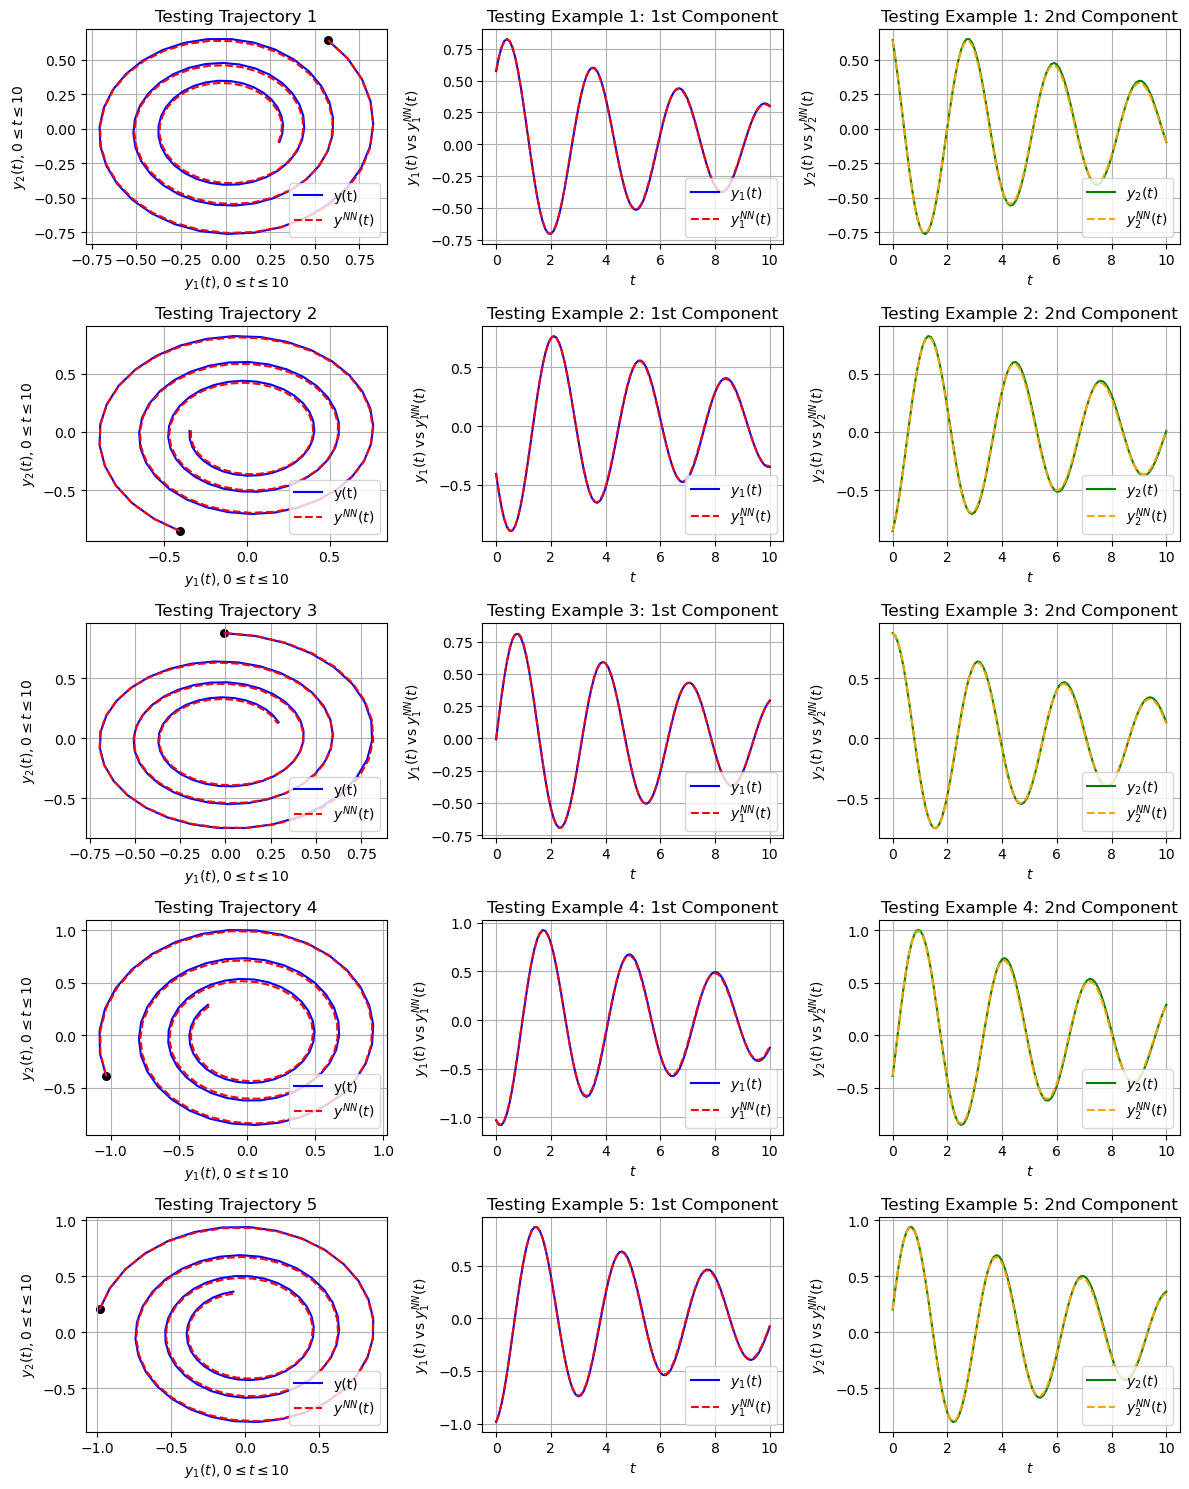

In [7]:
# generate testing dataset
ini_vals_test = [] # initial values
ref_trjs_test = [] # reference solution for each initial value

num_trjs_test = 5
np.random.seed(66) # for reproducibility
for _ in range(num_trjs_test):
    
    ratio = np.random.uniform(0.8, 1.2)
    angle = np.random.uniform(0, 2 * np.pi)
    ini_val = np.array([ratio * np.cos(angle), ratio * np.sin(angle)]) # initial value for each trajectory
    ini_vals_test.append(ini_val)
    
    # numerical solution through scipy
    ref_trj = solve_ivp(Exact_RHS_Func, (t_ini, t_end), ini_val, t_eval=smp_pts, dense_output=True, rtol=1e-8, atol=1e-8)
    ref_trjs_test.append(ref_trj.y.T) 

ini_vals_test = np.array(ini_vals_test) # shape: [num_trjs_test, 2]
ini_vals_test = torch.from_numpy(ini_vals_test).float().to(device)
ref_trjs_test = np.array(ref_trjs_test) # shape: [num_trjs_test, num_smps, 2]

ODE_NN.eval() 
with torch.no_grad(): 
    prd_trjs_test = ODE_NN(ini_vals_test, smp_pts)
    prd_trjs_test = prd_trjs_test.cpu().numpy() 

plt.figure(figsize=(12, 15))
for i in range(num_trjs_test):
    plt.subplot(num_trjs_test, 3, 3*i + 1)
    plt.plot(ref_trjs_test[i, :, 0], ref_trjs_test[i, :, 1], label='y(t)', color='blue')
    plt.plot(prd_trjs_test[i, :, 0], prd_trjs_test[i, :, 1], label='$y^{NN}(t)$', color='red', linestyle='--')
    plt.scatter(ini_vals_test[i, 0], ini_vals_test[i, 1], marker='o', color='black', s=30)
    plt.title(f'Testing Trajectory {i+1}')
    plt.xlabel(f'$y_1(t), 0\\leq t\\leq {t_end}$')
    plt.ylabel(f'$y_2(t), 0\\leq t\\leq {t_end}$')
    plt.legend(loc="lower right") 
    plt.grid(True)

    plt.subplot(num_trjs_test, 3, 3*i + 2)
    plt.plot(smp_pts, ref_trjs_test[i, :, 0], label='$y_1(t)$', color='blue')
    plt.plot(smp_pts, prd_trjs_test[i, :, 0], label='$y_1^{NN}(t)$', color='red', linestyle='--')
    plt.title(f'Testing Example {i+1}: 1st Component')
    plt.xlabel('$t$')
    plt.ylabel('$y_1(t)$ vs $y_1^{NN}(t)$')
    plt.legend(loc="lower right") 
    plt.grid(True)

    plt.subplot(num_trjs_test, 3, 3*i + 3)
    plt.plot(smp_pts, ref_trjs_test[i, :, 1], label='$y_2(t)$', color='green')
    plt.plot(smp_pts, prd_trjs_test[i, :, 1], label='$y_2^{NN}(t)$', color='orange', linestyle='--')
    plt.title(f'Testing Example {i+1}: 2nd Component')
    plt.xlabel('$t$')
    plt.ylabel('$y_2(t)$ vs $y_2^{NN}(t)$')
    plt.legend(loc="lower right") 
    plt.grid(True)
    
plt.tight_layout()
plt.show()